# Visualizing impulse responses of Echo State Networks

## Introduction

In this notebook, the impact of different hyper-parameters of an ESN are explained. The notebook depends on just a small variety of packages: numpy, matplotlib, IPython and pyrcn.

In [1]:
import os, sys
cwd = os.getcwd()
module_path = os.path.dirname(cwd)  # target working directory

sys.path = [item for item in sys.path if item != module_path]  # remove module_path from sys.path
sys.path.append(module_path)  # add module_path to sys.path

import numpy as np
from collections.abc import Iterable

%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
import seaborn as sns

sns.set_theme()

from pyrcn.echo_state_network import ESNRegressor

In [2]:
def build_visualization_widget(estimator, params, X, y):
    def visualize(estimator, constant_params, X, y, **interactive_params):
        params = constant_params.copy()
        params.update(interactive_params)
        estimator.set_params(**params).fit(X, y)
        sns.heatmap(data=estimator.hidden_layer_state.T)
        plt.xlabel("Time Step")
        plt.ylabel("Neuron Index")
    
    constant_params = dict()
    interactive_params = dict()
    for key, value in zip(params.keys(), params.values()):
        if isinstance(value, Iterable) and not isinstance(value, str):
            interactive_params[key] = value
        else:
            constant_params[key] = value
    interact(lambda **interactive_params: visualize(ESNRegressor(), constant_params, X, y, **interactive_params), **interactive_params)

In this notebook, we feed an example impulse through the ESN, treating it as a non-linear filter. The unit impuls starts at n=5.

Text(0, 0.5, 'X[n]')

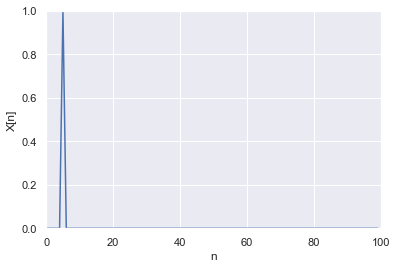

In [3]:
X = np.zeros(shape=(100, ), dtype=int)
X[5] = 1

fix, axs = plt.subplots()
sns.lineplot(x=range(100), y=X, ax=axs)
axs.set_xlim([0, 100])
axs.set_ylim([0, 1])
axs.set_xlabel('n')
axs.set_ylabel('X[n]')

At first, show the impact of different input scaling factors.

Therefore, we neutralize the other hyper-parameters, i.e., no recurrent connections ($\rho = 0$), no bias ($\alpha_{\mathrm{b}} = 0$) and no leakage ($\lambda = 1$). 

Visualizing this, we can see exactly what we might expect. We have chosen an input scaling factor of 0.1. Thus, the reservoir state is non-zero for exactly one sample. We can see that all reservoir states are zero all the times except for $n=5$, when the impulse is fed into the ESN. 

The absolute values of the reservoir states lie between 0 and 0.1.

If we increase the input scaling factor, each reservoir state still has only one non-zero value at $n=5$ as before, just with higher activations up to 0.8. The $\tanh$ non-linearity is damping the reservoir states so that they cannot reach 1.  

In [4]:
params = {'hidden_layer_size': 50,
          'input_activation': 'identity',
          'input_scaling': (0.1, 1.0, 0.1),
          'bias_scaling':  0.0,
          'spectral_radius': 0.0,
          'leakage': 1.0,
          'k_rec': 10,
          'reservoir_activation': 'tanh',
          'bi_directional': False,
          'random_state': 42}
build_visualization_widget(estimator=ESNRegressor(), params=params, X=X.reshape(-1, 1), y=X)

interactive(children=(FloatSlider(value=0.5, description='input_scaling', max=1.0, min=0.1), Output()), _dom_c…

Let's keep the input scaling factor fixed to 1.0 for the next experiments. Echo State Networks have two ways to
incorporate past information.

Next, let us analyze the spectral radius. Therefore, we set it to 0.3 in the following example.

We can observe that the impulse responses are starting at n=5 and decaying until reaching zero after a short time. Obviously, the reservoir states are decaying rather fast, because the recurrent connections are small compared to the input scaling. 

If we increase the spectral radius close to 1.0, the values are still bounded between [0.8, 0.8], but the reservoir states are active over a longer time now.

If we further increase the spectral radius, we can see that the reservoir states are decaying very slowly, and they are oscillating with a resonance frequency. For many tasks, it is indeed necessary to preserve the echo state property of reservoir and keep 𝜌<1. However in some cases, such as time-series prediction, the spectral radius can be larger than 1. 

In [5]:
params = {'hidden_layer_size': 50,
          'input_activation': 'identity',
          'input_scaling': 1.0,
          'bias_scaling':  0.0,
          'spectral_radius': (0.0, 2.0, 0.1),
          'leakage': 1.0,
          'k_rec': 10,
          'reservoir_activation': 'tanh',
          'bi_directional': False,
          'random_state': 42}
build_visualization_widget(estimator=ESNRegressor(), params=params, X=X.reshape(-1, 1), y=X)

interactive(children=(FloatSlider(value=1.0, description='spectral_radius', max=2.0), Output()), _dom_classes=…

For some use cases, the reservoir should behave more non-linear. Therefore, we can play around with the bias. Here, we
will show the impact of the bias scaling factor just for one example and increase it to 0.2.

The spectral radius is decreased to 0.9 in order to fulfil the Echo State Property.

Two impacts of the bias scaling can be mainly observed: (1) The absolute value of the stable states of the reservoir neurons is approximately distributed from 0 to 0.2 and each neuron has its own stable state. When new information from the input is passed to the reservoir neurons, this is the excitation point. (2) Before the impulse arrives in the reservoir (𝑛=5), the states are approaching their stable state. Due to the spectral radius, each reservoir neuron is connected to other neurons and thus feeds the constant bias through the network, until each neuron has reached its final state.

In [6]:
params = {'hidden_layer_size': 50,
          'input_activation': 'identity',
          'input_scaling': 1.0,
          'bias_scaling':  (0.0, 2.0, 0.1),
          'spectral_radius': 0.9,
          'leakage': 1.0,
          'k_rec': 10,
          'reservoir_activation': 'tanh',
          'bi_directional': False,
          'random_state': 42}
build_visualization_widget(estimator=ESNRegressor(), params=params, X=X.reshape(-1, 1), y=X)

interactive(children=(FloatSlider(value=1.0, description='bias_scaling', max=2.0), Output()), _dom_classes=('w…

Finally, let us observe the impact of the leakage. Leaky integration is the other way to incorporate past information
into the reservoir. This works by keeping the previous reservoir states over a longer time.

The leakage behaves in the same way for all nodes in the reservoir and acts like a low-pass filter. The magnitude is strongly damped, and all reservoir states are decaying exponentially over a longer time. Due to the spectral radius, all neurons have individual decaying times.

In [7]:
params = {'hidden_layer_size': 50,
          'input_activation': 'identity',
          'input_scaling': 1.0,
          'bias_scaling':  0.0,
          'spectral_radius': 0.9,
          'leakage': (0.1, 1.0, 0.1),
          'k_rec': 10,
          'reservoir_activation': 'tanh',
          'bi_directional': False,
          'random_state': 42}
build_visualization_widget(estimator=ESNRegressor(), params=params, X=X.reshape(-1, 1), y=X)

interactive(children=(FloatSlider(value=0.5, description='leakage', max=1.0, min=0.1), Output()), _dom_classes…

If we would like to incorporate future information into the reservoir, we can pass our input samples for- and backward
through the reservoir. Therefore, we set bidirectional to True.

We can see the clear effect of usind bidirectional ESNs:

Because of the additional backward-pass, the number of reservoir states is doubled, and we can see that they decay in both, forward and backward direction. This is especially useful for some classification tasks.

In [8]:
params = {'hidden_layer_size': 50,
          'input_activation': 'identity',
          'input_scaling': 1.0,
          'bias_scaling':  0.0,
          'spectral_radius': 0.9,
          'leakage': 1.0,
          'k_rec': 10,
          'reservoir_activation': 'tanh',
          'bi_directional': [False, True],
          'random_state': 42}
build_visualization_widget(estimator=ESNRegressor(), params=params, X=X.reshape(-1, 1), y=X)

interactive(children=(Dropdown(description='bi_directional', options=(False, True), value=False), Output()), _…

Try to play around with all these hyper-parameters!

In [9]:
params = {'hidden_layer_size': 50,
          'input_activation': 'identity',
          'input_scaling': (0.1, 1.0, 0.1),
          'bias_scaling':  (0.0, 0.5, 0.1),
          'spectral_radius': (0.0, 1.5, 0.1),
          'leakage': (0.1, 1.0, 0.1),
          'k_rec': 10,
          'reservoir_activation': 'tanh',
          'bi_directional': [False, True],
          'random_state': 42}
build_visualization_widget(estimator=ESNRegressor(), params=params, X=X.reshape(-1, 1), y=X)

interactive(children=(FloatSlider(value=0.5, description='input_scaling', max=1.0, min=0.1), FloatSlider(value…